In [1]:
import json
from web3 import Web3
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# def check_swap_transactions(tx, router_address, abi_file='uniswap_router02.json'):
#     function_names = ['swapExactTokensForTokens', 'swapExactETHForTokens', 'swapTokensForExactETH']
#     INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
#     web3 = Web3(Web3.HTTPProvider(INFURA_URL))
#     with open(abi_file, 'r') as file:
#         router_abi = json.load(file)

#     contract = web3.eth.contract(address=router_address, abi=router_abi)
#     decoded_input = contract.decode_function_input(tx['input'])
#     function_name = decoded_input[0].fn_name
    
#     return function_name in function_names


# def num_transactions(txs, cex_router):
#     sender_num_deals = {}
#     for tx in txs:
#         if tx['from'] not in sender_num_deals.keys():
#             sender_num_deals[tx['from']] = 1
#         else:
#             sender_num_deals[tx['from']] += 1
#             if tx['to'] in cex_router:
#                 continue

    

# def count_dex_transactions(blocks, dex_router, cex_router):
#     INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
#     web3 = Web3(Web3.HTTPProvider(INFURA_URL))

#     block_dex_deals = {}
#     block_arbitr_deals = {}

#     for b in blocks:
#         block = web3.eth.get_block(b, full_transactions=True)
#         txs = block['transactions']
#         idx_dex = {}
#         idx_not_dex = {}
        
#         for i, tx in enumerate(txs):
#             if tx['to'] in dex_router:
#                 if check_swap_transactions(tx, dex_router[0]):
#                     if tx['from'] not in idx_dex.keys():
#                         idx_dex[tx['from']] = [i]
#                     else:
#                         idx_dex[tx['from']].append(i)

#                     if b not in block_dex_deals.keys():
#                         block_dex_deals[b] = 1
#                     else:
#                         block_dex_deals[b] += 1
#             else:
#                 if tx['from'] not in idx_not_dex.keys():
#                     idx_not_dex[tx['from']] = [i]
#                 else:
#                     idx_not_dex[tx['from']].append(i)
        
#         common_senders = set(idx_dex.keys()) & set(idx_not_dex.keys())
#         # num_arbitr = 0
#         # for sender in common_senders:
#         #     for idx in idx_not_dex[sender]:
#         #          num_arbitr += 1
#             #     if txs[idx]['to'] in cex_router:
#             #         num_arbitr += 1

#         block_arbitr_deals[b] = len(common_senders)
    # return block_dex_deals, block_arbitr_deals

In [2]:
def check_swap_transactions(tx, router_address, abi_file='uniswap_router02.json'):
    function_names = ['swapExactTokensForTokens', 'swapExactETHForTokens', 'swapTokensForExactETH']
    INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
    web3 = Web3(Web3.HTTPProvider(INFURA_URL))
    with open(abi_file, 'r') as file:
        router_abi = json.load(file)

    contract = web3.eth.contract(address=router_address, abi=router_abi)
    decoded_input = contract.decode_function_input(tx['input'])
    function_name = decoded_input[0].fn_name
    function_args = decoded_input[1]

    # Возвращаем информацию о токенах и их количестве
    if function_name in function_names:
        path = function_args['path']
        token_abi = [
        {
            "constant": True,
            "inputs": [],
            "name": "decimals",
            "outputs": [{"name": "", "type": "uint8"}],
            "type": "function",
        },
        {
            "constant": True,
            "inputs": [],
            "name": "symbol",
            "outputs": [{"name": "", "type": "string"}],
            "type": "function",
        },
    ]
        
        
        try:
            token_contract = web3.eth.contract(address=path[0], abi=token_abi)
            tokenIn_symbol = token_contract.functions.symbol().call()
            decimals_in = token_contract.functions.decimals().call()
        except Exception as e:
            tokenIn_symbol = "UNKNOWN"
            decimals_in = -1
        
        try:
            token_contract = web3.eth.contract(address=path[-1], abi=token_abi)
            tokenOut_symbol = token_contract.functions.symbol().call()
            decimals_out = token_contract.functions.decimals().call()
        except Exception as e:
            tokenOut_symbol = "UNKNOWN"
            decimals_out = -1
        
        if function_name == 'swapExactTokensForTokens':
            return function_name, function_args['amountIn']/(10 ** decimals_in), function_args['amountOutMin']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
        elif function_name == 'swapExactETHForTokens':
            return function_name, tx['value']/(10 ** decimals_in), function_args['amountOutMin']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
        elif function_name == 'swapTokensForExactETH':
            return function_name, function_args['amountInMax']/(10 ** decimals_in), function_args['amountOut']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
    
    return None, None, None, None, None, None, None




def count_dex_transactions(blocks, dex_router, cex_router):
    INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
    web3 = Web3(Web3.HTTPProvider(INFURA_URL))

    block_dex_deals = {}
    block_arbitr_deals = {}
    token_stats = {}
    block_path = {}

    for b in blocks:
        block = web3.eth.get_block(b, full_transactions=True)
        txs = block['transactions']
        idx_dex = {}
        idx_not_dex = {}
        
        for i, tx in enumerate(txs):
            if tx['to'] in dex_router:
                # amount_in, amount_out -- сколько штук отдаем и получаем
                # token_in, token_out -- названия токенов которые продаем и получаем
                function_name, amount_in, amount_out, path, num_tokens, token_in, token_out = check_swap_transactions(tx, dex_router[0])
                
                if function_name:
                    if tx['from'] not in idx_dex.keys():
                        idx_dex[tx['from']] = [i]
                    else:
                        idx_dex[tx['from']].append(i)

                    if b not in block_dex_deals.keys():
                        block_dex_deals[b] = 1
                        block_path[b] = [[amount_in, amount_out, num_tokens, token_in, token_out]]
                    else:
                        block_dex_deals[b] += 1
                        block_path[b].append([amount_in, amount_out, num_tokens, token_in, token_out])

                    # Учет обмененных токенов
                    # if b not in token_stats:
                    #     token_stats[b] = {}
                    # for token_address in path:
                    #     if token_address not in token_stats[b]:
                    #         token_stats[b][token_address] = 0
                    #     token_stats[b][token_address] += amount_in or amount_out
            else:
                if tx['from'] not in idx_not_dex.keys():
                    idx_not_dex[tx['from']] = [i]
                else:
                    idx_not_dex[tx['from']].append(i)
        
        common_senders = set(idx_dex.keys()) & set(idx_not_dex.keys())
        block_arbitr_deals[b] = len(common_senders)
                    
    return block_dex_deals, block_arbitr_deals, block_path

In [ ]:
blocks = range(12343677, 12343777, 1)
# blocks = [12343677]
dex_router = ['0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D']
cex_router = [
    "0x28c6c06298d514db089934071355e5743bf21d60",  # Binance Hot Wallet
    "0x8f22f2063d253846b53609231ed80fa571bc2e0f",  # Coinbase Wallet (ETH)
    "0x0a869d79a7052c7f1b55a8ebabbea3420f0d1e13",  # Kraken Wallet
    "0xDC76CD25977E0A5Ae17155770273aD58648900D3",  # Huobi Hot Wallet
    "0xa6a5f4c502f7fa1d22d8c13f23ed6927df9a6ec7",  # KuCoin Hot Wallet
    "0x876eabf441b2ee5b5b0554fd502a8e0600950cfa",  # Bitfinex Wallet (ETH)
    "0x5c985e89dde482efe97ea9f1950ad149eb73829b",  # OKX Wallet
    "0x3f5ce5fbfe3e9af3971ddf4b9d51841c90696e43",  # Gate.io Hot Wallet
    "0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2",  # Bybit Wallet
    "0x401F6c983eA34274ec46f84D70b31C151321188b"   # Bitstamp Wallet
]

block_dex_deals, block_arbitr_deals, block_paths = count_dex_transactions(blocks, dex_router, cex_router)

In [ ]:
token_in_name_amount = {}
token_out_name_amount = {}
token_in_name_amount_sum = {}
token_out_name_amount_sum = {}

for arrs in block_paths.values():
    for params in arrs:
        amount_in, amount_out, token_in, token_out = params[0], params[1], params[3], params[4]
        if token_in not in token_in_name_amount:
            token_in_name_amount[token_in] = [amount_in]
            token_in_name_amount_sum[token_in] = amount_in
        else:
            token_in_name_amount[token_in].append(amount_in)
            token_in_name_amount_sum[token_in] += amount_in

        if token_out not in token_out_name_amount:
            token_out_name_amount[token_out] = [amount_out]
            token_out_name_amount_sum[token_out] = amount_out
        else:
            token_out_name_amount[token_out].append(amount_out)
            token_out_name_amount_sum[token_out] += amount_out

In [36]:
token_in_name_amount

{'DAI': [50000.0,
  17998.251657295426,
  2321.9777686746293,
  47.92938166,
  1000.0,
  1841.7314608059185,
  100.0,
  2321.9777686746297,
  1200.0,
  5000.0,
  39188.15880700663,
  601.8310991998993,
  1000.0,
  50000.0,
  50000.0,
  15421.469615526625,
  1100.0],
 'WETH': [0.075925952,
  0.1939027224805829,
  0.1,
  0.18,
  0.08,
  0.18,
  3.1223981684716855,
  0.161721323125,
  0.15,
  3.0,
  2.0,
  1.0,
  0.006202773229871347,
  0.19225267,
  0.02,
  0.2,
  0.0317225221431746,
  0.3228210622301146,
  0.13,
  5.0,
  8.11,
  0.1,
  0.075,
  0.25,
  0.185,
  0.1,
  0.2401395937224988,
  0.1013,
  0.3,
  0.0209641845,
  0.08,
  0.08628496194060072,
  0.479716,
  0.00984816156403513,
  0.1,
  0.31,
  1.5,
  0.11,
  0.45,
  1.0,
  0.05,
  0.08,
  0.13,
  1.0,
  0.3,
  5.0,
  0.11,
  0.04,
  0.0005,
  1.0,
  0.011,
  0.195,
  4.0,
  3.0,
  0.2695892538128907,
  0.25,
  0.5,
  0.1,
  0.072,
  1.7026,
  0.2,
  0.1,
  0.2,
  5.1,
  0.1,
  2.0,
  0.16,
  2.0,
  0.1677217852,
  0.05463456,
  

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (231,) + inhomogeneous part.

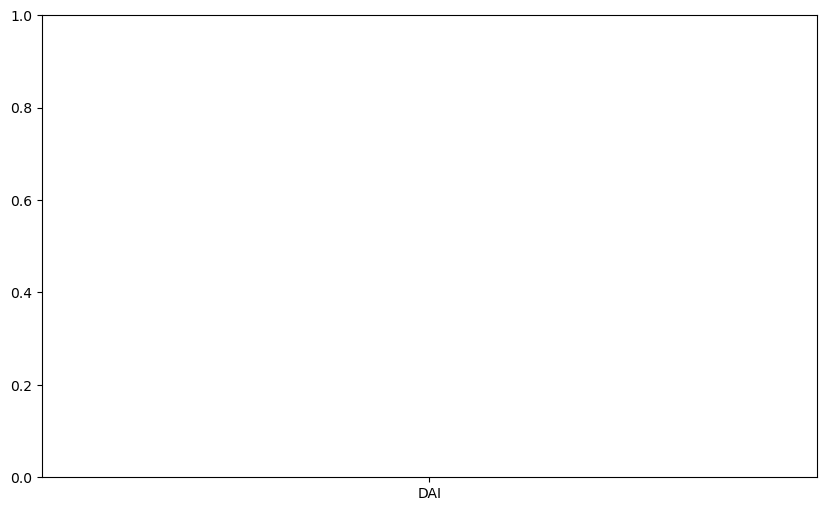

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(token_in_name_amount.keys(), token_in_name_amount.values())

plt.xlabel('Token Symbol')
plt.ylabel('Amount of Token')
plt.xticks(rotation=45)
plt.title('Amount of Tokens IN')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (367,) + inhomogeneous part.

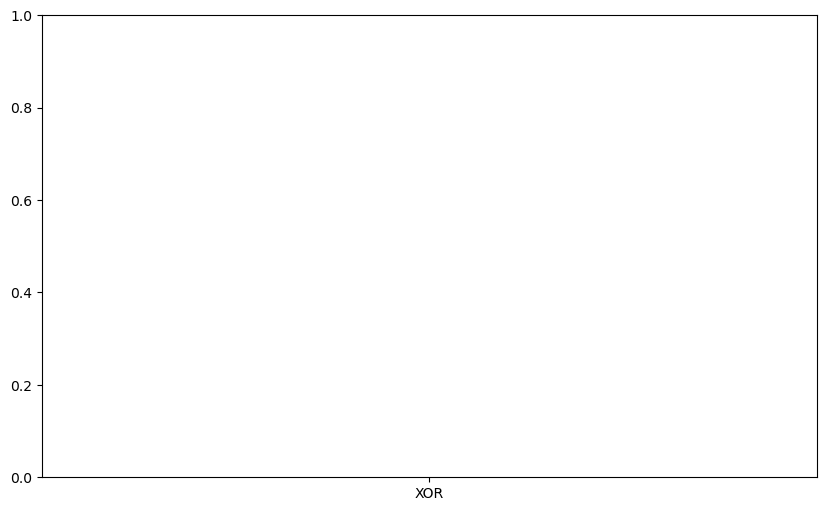

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(token_out_name_amount.keys(), token_out_name_amount.values())

plt.xlabel('Token Symbol')
plt.ylabel('Amount of Token')
plt.xticks(rotation=45)
plt.title('Amount of Tokens OUT')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [13]:
block_num_deals, block_arbitr_deals

({12343677: 15,
  12343678: 17,
  12343679: 14,
  12343680: 13,
  12343681: 20,
  12343682: 15,
  12343683: 7,
  12343684: 23,
  12343685: 18,
  12343686: 4,
  12343687: 14,
  12343688: 14,
  12343689: 22,
  12343690: 13,
  12343691: 6,
  12343693: 14,
  12343694: 15,
  12343695: 14,
  12343696: 13,
  12343697: 19,
  12343698: 18,
  12343699: 18,
  12343700: 33,
  12343701: 24,
  12343702: 11,
  12343703: 18,
  12343704: 9,
  12343705: 18,
  12343706: 8,
  12343707: 13,
  12343708: 21,
  12343709: 15,
  12343710: 12,
  12343711: 36,
  12343712: 18,
  12343713: 23,
  12343714: 15,
  12343715: 19,
  12343716: 15,
  12343717: 6,
  12343718: 25,
  12343719: 25,
  12343720: 19,
  12343721: 23,
  12343722: 12,
  12343723: 22,
  12343724: 23,
  12343725: 19,
  12343726: 20,
  12343727: 15,
  12343728: 19,
  12343729: 9,
  12343730: 26,
  12343731: 25,
  12343732: 29,
  12343733: 9,
  12343734: 10,
  12343735: 30,
  12343736: 23,
  12343737: 13,
  12343738: 10,
  12343739: 13,
  12343740: 24,


In [16]:
np.mean(list(block_num_deals.values()))

17.591836734693878